In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers.normalization import BatchNormalization
from keras.activations import elu
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model

In [22]:
from fonction import *

In [23]:
# Definition of the path of the data
data_path = 'C:\\Users\\pierr\\Desktop\\Projet de semestre I\\data\\train_set\\mesh_square_B\\data_set_B_3_simple.csv'

In [24]:
# load the data 
data = np.loadtxt(data_path, delimiter=',')
ind = data[:,0]
data= data[:,1:]
data.shape

(9700, 41)

In [25]:
X_train, X_test, Y_train, Y_test, indice_neg_data,ind_neg_x_test = data_preparation(data)

In [26]:
# check the size of the training and test set :
print(" the size of X_train is ",np.shape(X_train))
print(" the size of X_test is ",np.shape(X_test))
print(" the size of Y_train is ",np.shape(Y_train))
print(" the size of Y_test is ",np.shape(Y_test))

 the size of X_train is  (7760, 40)
 the size of X_test is  (1940, 40)
 the size of Y_train is  (7760, 1)
 the size of Y_test is  (1940, 1)


{'whiskers': [<matplotlib.lines.Line2D at 0x2343b338eb8>,
 'caps': [<matplotlib.lines.Line2D at 0x2343b356550>,
 'boxes': [<matplotlib.lines.Line2D at 0x2343b338a90>],
 'medians': [<matplotlib.lines.Line2D at 0x2343b356be0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2343b356f28>],
 'means': []}

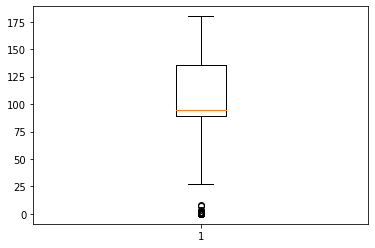

In [7]:
plt.boxplot(Y_test*180/np.pi)

In [74]:
def build_model_base_line(summary = True):
    
    #architecture
    model = Sequential()
    model.add(Dense(1 ,input_shape=(40,)))
    if summary :
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

===================NN architecture==========================
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 1)                 41        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
None
=======================training=============================
Epoch 00450: early stopping
MSE Train: 0.780 | MSE Test: 0.787


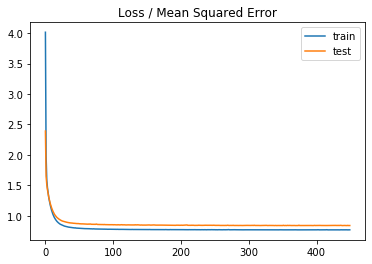

Training time is : 0.30  minute
======================Saving model==========================
Saved model to disk


In [75]:
model_base, train_mse , test_mse = training_NN(build_model_base_line,X_train, X_test, Y_train, Y_test,"model_bl_data_6.h5",batch=100)

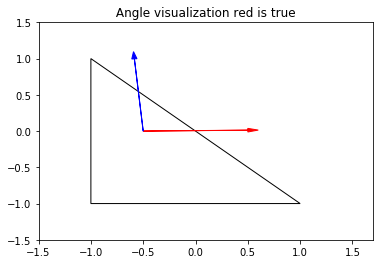

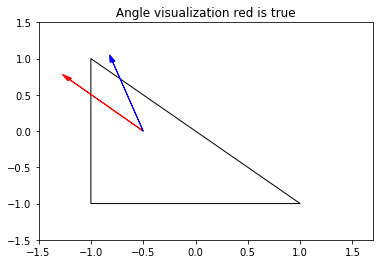

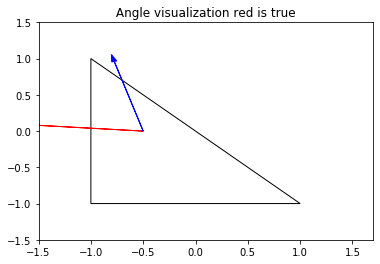

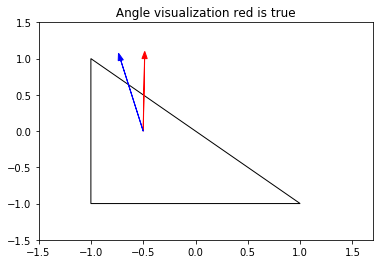

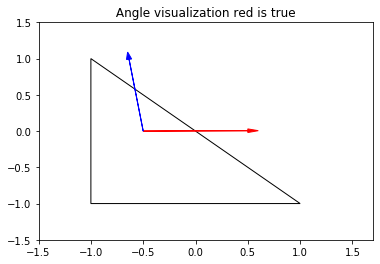

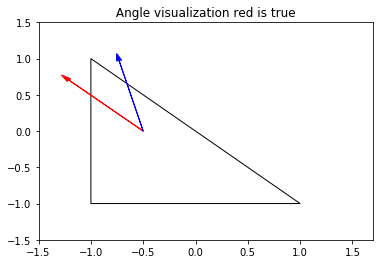

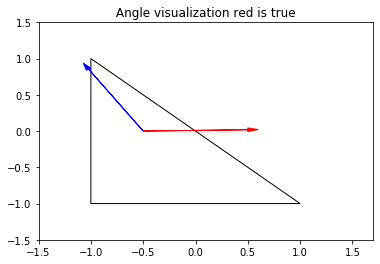

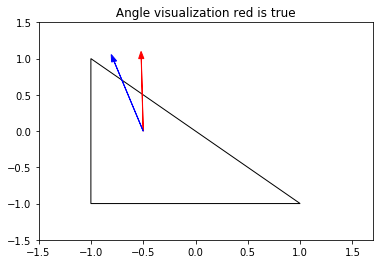

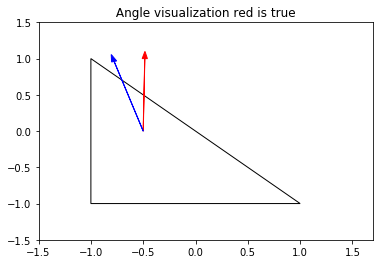

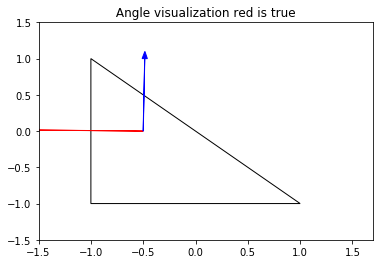

In [49]:
angle_visualization(model_base , X_test , Y_test)

In [29]:
def build_model_3_tanh(summary = True):
    
    #architecture
    model = Sequential()
    
    model.add(Dense(40 ,input_shape=(40,)))
    model.add(BatchNormalization())        
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
              
    model.add(Dense(40))
    model.add(BatchNormalization())        
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
              
    model.add(Dense(40))
    model.add(BatchNormalization())        
    model.add(Activation('relu'))
    
    model.add(Dense(1))
              
    if summary:
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

===================NN architecture==========================
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 40)                1640      
_________________________________________________________________
batch_normalization_24 (Batc (None, 40)                160       
_________________________________________________________________
activation_24 (Activation)   (None, 40)                0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 40)                1640      
_________________________________________________________________
batch_normalization_25 (Batc (None, 40)                160       
__________________________________________________________

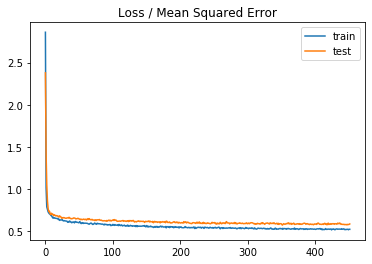

Training time is : 0.84  minute
======================Saving model==========================
Saved model to disk


In [73]:
model_3_tanh, train_mse , test_mse = training_NN(build_model_3_tanh,X_train, X_test, Y_train, Y_test,"test.h5",batch = 100)

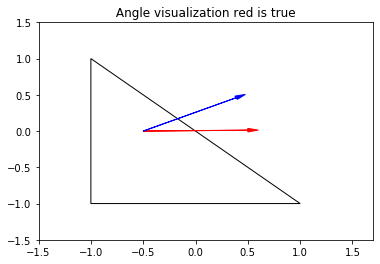

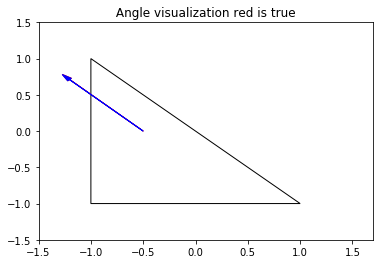

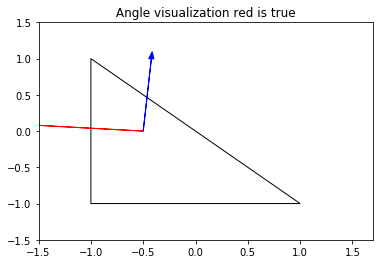

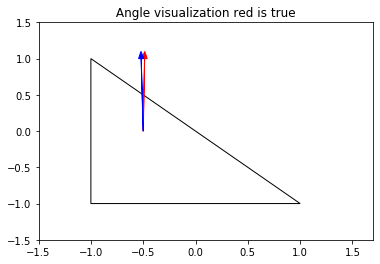

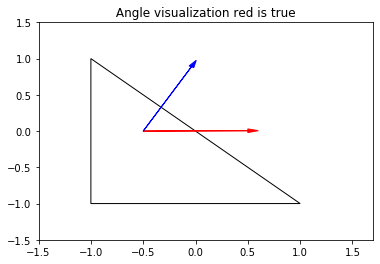

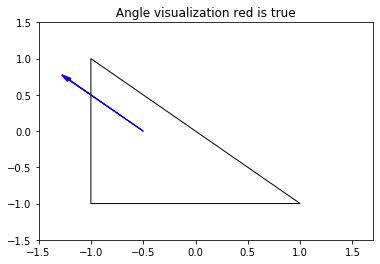

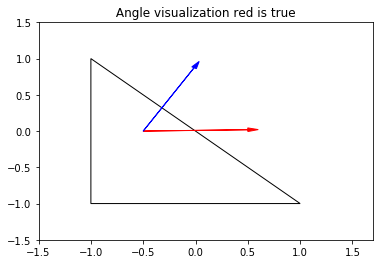

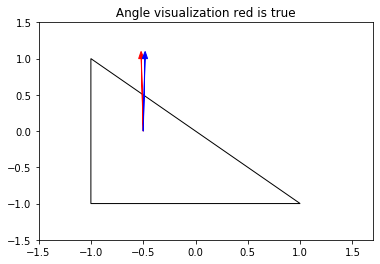

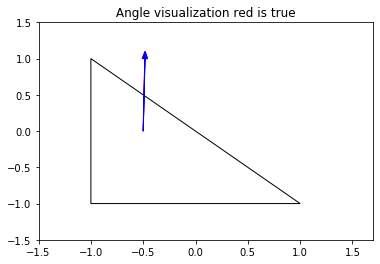

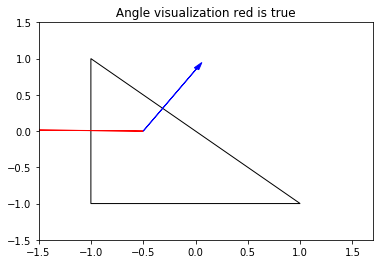

In [81]:
angle_visualization(model_3_tanh , X_test , Y_test)

### Analyse of the problem


In [9]:
Y_hat =  model_3_tanh.predict(X_test, verbose=0)

In [10]:
error = Y_hat-Y_test

In [16]:
indice = np.where(np.abs(error) >=1)[0]
print(indice.shape[0])

364


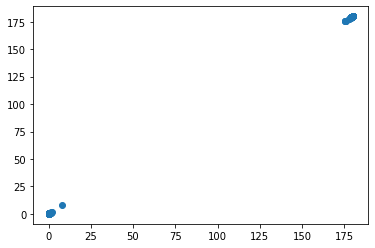

In [12]:
plt.scatter(Y_test[indice]*180/np.pi,Y_test[indice]*180/np.pi)

we can see that the model strugle with the angle in the reference element that is near zero or near pi 

the location of the discontinuity is really often in the top of the triangle. their is only horizontal discontinuity


In [106]:
X_test[indice[10]]

array([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 1.])

In [18]:
max_ = (np.where(Y_test[indice]*180/np.pi>150)[0]).shape[0]
n=0
for i in indice :
    if Y_test[i]*180/np.pi > 150 :
        if i in ind_neg_x_test:
            n +=1
print(max_)
print(n)
        

180
79


In [19]:
max_ = (np.where(Y_test[indice]*180/np.pi<150)[0]).shape[0]
n=0
for i in indice :
    if Y_test[i]*180/np.pi < 150 :
        if i in ind_neg_x_test:
            n +=1
print(max_)
print(n)

184
98


The problem come from the fact that if we have an horizontak discontinuity in the reference element then their is multipole interpretation and the NN is lost .

let's try to see if i have wrigth. we will take wlog that an horizontal discontinuity is define by an angle of zero

In [31]:
indice_up_170 = np.where(Y_train*180/np.pi > 170)[0]
Y_train_new = np.copy(Y_train)
Y_train_new[indice_up_170] -= np.pi

In [32]:
indice_up_170 = np.where(Y_test*180/np.pi > 170)[0]
Y_test_new = np.copy(Y_test)
Y_test_new[indice_up_170] -= np.pi


===================NN architecture==========================
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 40)                1640      
_________________________________________________________________
batch_normalization_4 (Batch (None, 40)                160       
_________________________________________________________________
activation_4 (Activation)    (None, 40)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 40)                1640      
_________________________________________________________________
batch_normalization_5 (Batch (None, 40)                160       
___________________________________________________________

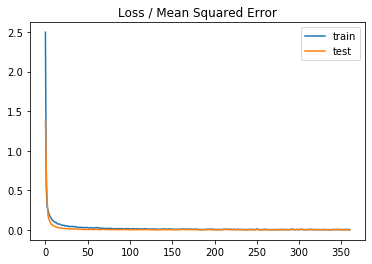

Training time is : 0.64  minute
======================Saving model==========================
Saved model to disk


In [33]:
model_fix , train_mse , test_mse = training_NN(build_model_3_tanh,X_train, X_test, Y_train_new, Y_test_new,"test.h5",batch = 100)

### Making prediction :

In [8]:
from keras.models import load_model
model_3_tanh = load_model('test.h5')

In [76]:
data_path_test_1 = 'C:\\Users\\pierr\\Desktop\\Projet de semestre I\\data\\test_set\\mesh_square\\data_test_set_6_30.csv'

In [77]:
test_mse = prediction_on_new_grid(data_path_test_1,'\data\pred_data_set_B_3_30.csv',model_3_tanh,normalized=True)

loading data ... 
loading succed
on a new mesh the mse is : 0.8511
saving prediction ...
saving succed


In [36]:
data_path_test_2 = 'C:\\Users\\pierr\\Desktop\\Projet de semestre I\\data\\test_set\\mesh_square\\data_test_set_6_60.csv'

loading data ... 
loading succed
on a new mesh the mse is : 1.1752


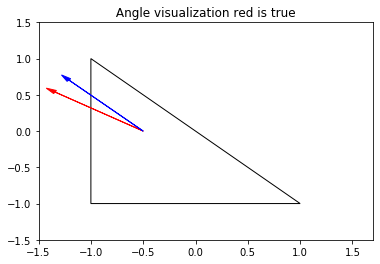

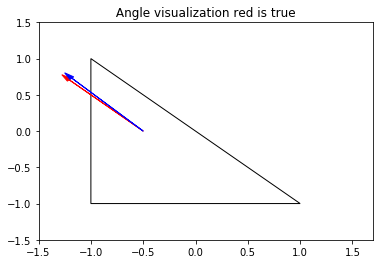

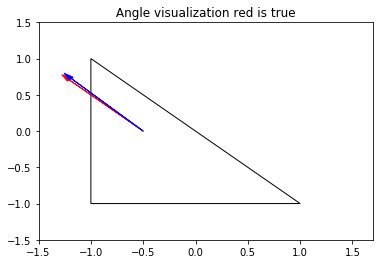

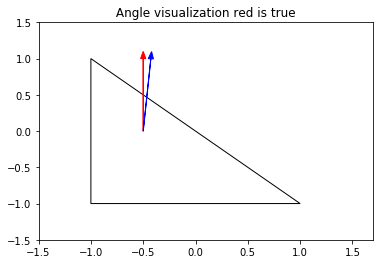

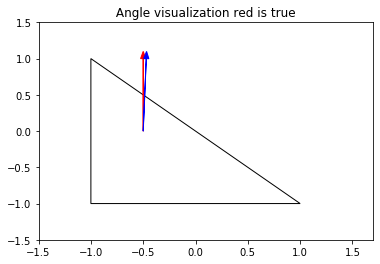

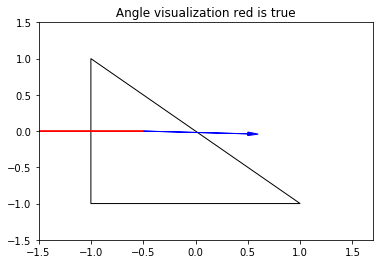

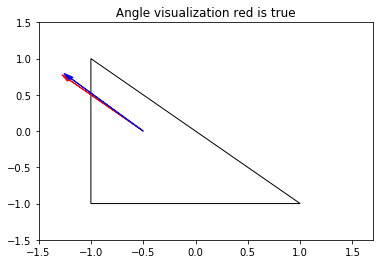

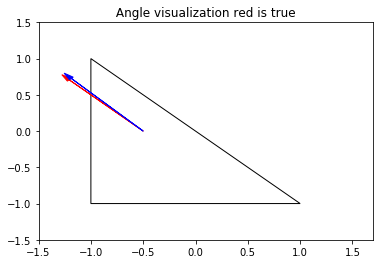

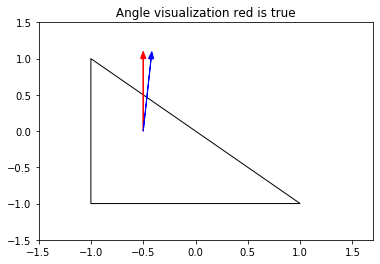

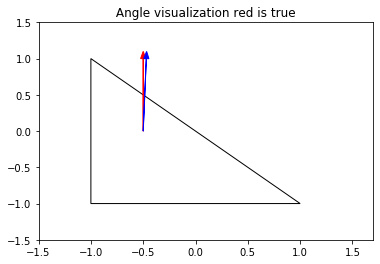

saving prediction ...
saving succed


In [37]:
test_mse  = prediction_on_new_grid(data_path_test_2,'\data\pred_data_set_B_3_60.csv',model_fix,vizu = True ,normalized=True)